# Post-SpaceM QC

This is a Python port of Martijn's R notebook

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_formats = ["retina"]

sns.set(
    style="ticks",
    context="notebook"
)

### Enter the parent directory containing your datasets here 👇

In [9]:
spacem_dir = Path("./data") #directory for raw anndata
#pixel size obtained from microscopy metadata
um_per_px = 0.64

This notebook will detect all child directories containing SpaceM datasets.

In [10]:
dataset_names = {
    'B1': 'NStim_B1',
    'C1': 'NStim_C1',
    'D1': 'NStim_D1',
    'E1': 'NStim_E1',
    'G1': 'NStim_G1',
    'A2': 'Stim_A2',
    'E2': 'Stim_E2',
    'F2': 'Stim_F2',
    'I2': 'Stim_I2',
    'J2': 'Stim_J2',
    'A3': '2DG_A3',
    'B3': '2DG_B3',
    'E3': '2DG_E3',
    'F3': '2DG_F3',
    'H3': '2DG_H3',
    'B4': 'Oligo_B4',
    'E4': 'Oligo_E4',
    'F4': 'Oligo_F4',
    'G4': 'Oligo_G4',
    'H4': 'Oligo_H4' 
}

In [11]:
am_matrices = []

for am_matrix_file in spacem_dir.glob(
    "**/analysis/ablation_mark_analysis/spatiomolecular_matrix.csv"
):
    dataset_name = "/".join(am_matrix_file.relative_to(spacem_dir).parts[:-3])
    dataset_name = dataset_names[dataset_name] #Use dicitionary to rename dataset
    
    print(am_matrix_file, "-->", dataset_name)

    am_matrix_long = pd.read_csv(am_matrix_file)

    am_matrix_long["x"] = (am_matrix_long.am_id - 1) // 100
    am_matrix_long["y"] = (am_matrix_long.am_id - 1) % 100

    am_matrix_long["dataset"] = dataset_name
    am_matrices.append(am_matrix_long)

am_matrix = pd.concat(am_matrices, ignore_index=True)
del am_matrices

ValueError: No objects to concatenate

In [7]:
sc_matrices = []

for sc_matrix_file in spacem_dir.glob(
    "**/analysis/single_cell_analysis/spatiomolecular_matrix.csv"
):
    dataset_name = "/".join(sc_matrix_file.relative_to(spacem_dir).parts[:-3])
    dataset_name = dataset_names[dataset_name]
    
    print(sc_matrix_file, "-->", dataset_name)

    sc_matrix_long = pd.read_csv(sc_matrix_file)

    sc_matrix_long["dataset"] = dataset_name
    sc_matrices.append(sc_matrix_long)

sc_matrix = pd.concat(sc_matrices, ignore_index=True)
del sc_matrices

weightoverlap_rawanndata\s1\w5\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> MiaPaca2 mes s1
weightoverlap_rawanndata\s1\w6\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> PSN1 mes s1
weightoverlap_rawanndata\s1\w7\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> HPAF epi s1
weightoverlap_rawanndata\s1\w8\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> HPAC epi s1
weightoverlap_rawanndata\s2\w5\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> MiaPaca2 mes s2
weightoverlap_rawanndata\s2\w6\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> PSN1 mes s2
weightoverlap_rawanndata\s2\w7\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> HPAF epi s2
weightoverlap_rawanndata\s2\w8\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> HPAC epi s2
weightoverlap_rawanndata\s3\w5\analysis\single_cell_analysis\spatiomolecular_matrix.csv --> MiaPaca2 mes s3
weightoverlap_rawanndata\s3\w6\analysis\single_cell_

In [8]:
n_datasets = len(am_matrix.dataset.unique())

In [9]:
mol_cols = am_matrix.columns.to_series().filter(regex="C[0-9]+").index

In [10]:
coverage_df = am_matrix.groupby(["dataset"])[mol_cols].apply(lambda x: x.isna().all(axis=0) == False)

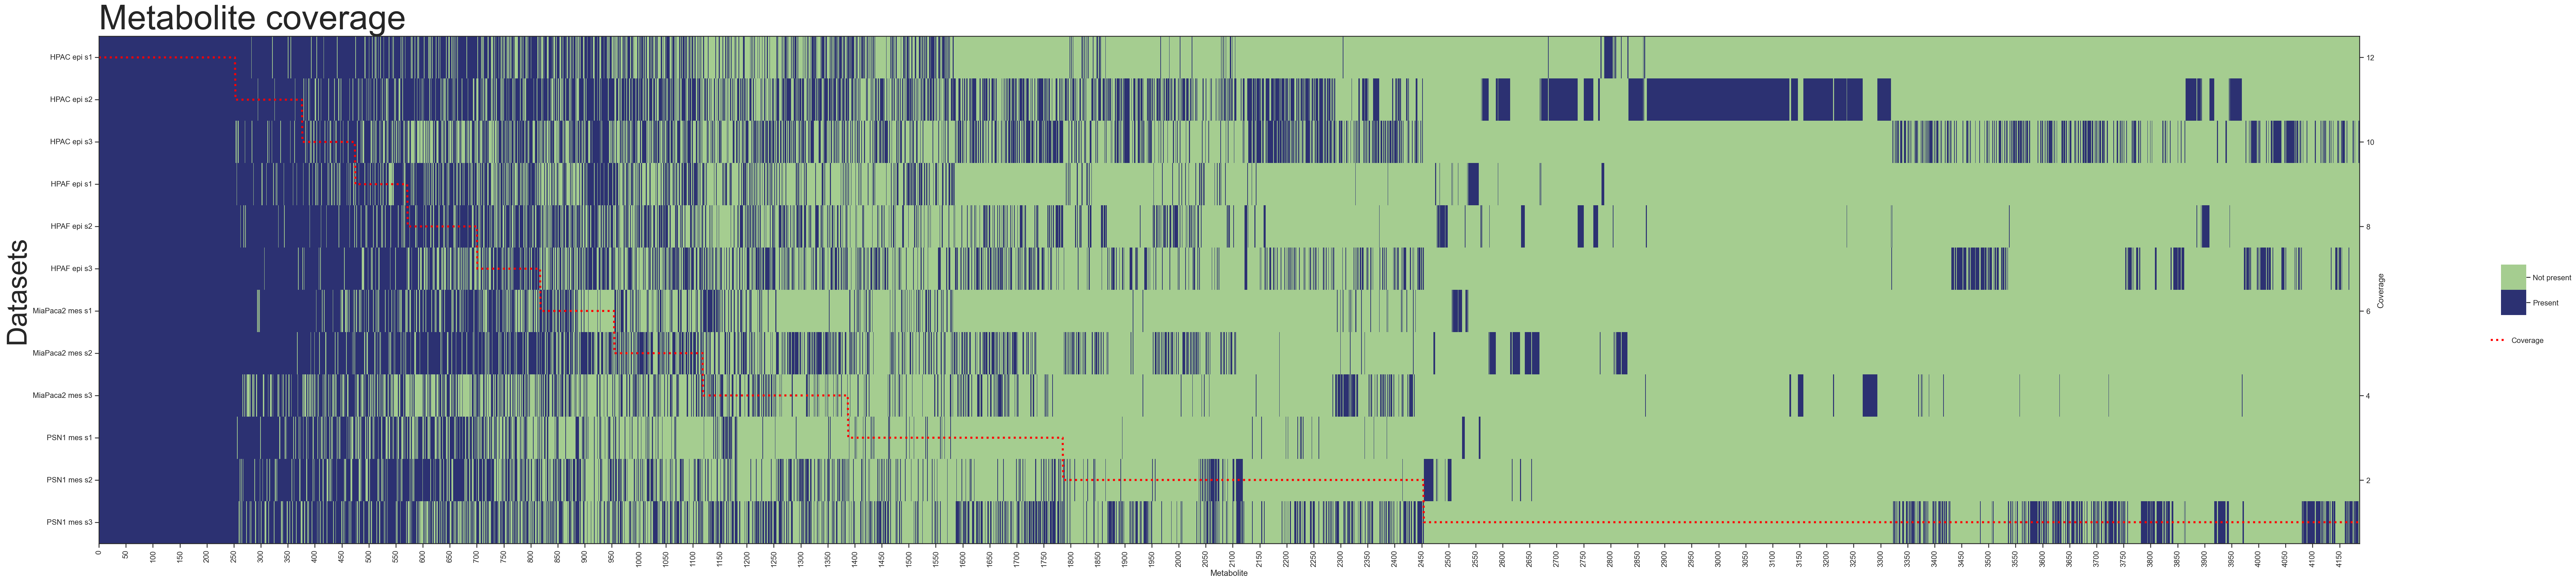

In [12]:
formula_idx = coverage_df.sum(axis=0).sort_values(ascending=False).index

coverage_df = coverage_df[formula_idx]
coverage_sum = coverage_df.sum(axis=0)

fig = plt.figure(figsize=[coverage_df.shape[1] / 70, coverage_df.shape[0]])
ax1 = sns.heatmap(
    coverage_df,
    cmap="crest",
    cbar_kws={"ticks": [0.25, 0.75], "values": [0, 1], "aspect": 2, "shrink": 0.1},
)
plt.xlabel("Metabolite")
plt.ylabel("Datasets", size=40)
fig.axes[1].set_yticklabels(["Present", "Not present"])
ticks = np.arange(0, coverage_df.shape[1], 50)
plt.xticks(ticks, ticks)

ax2 = ax1.twinx()
ax2.plot(range(len(coverage_sum)), coverage_sum, linestyle=":", linewidth=3, c="Red")
ax2.set_ylim(0.5, len(coverage_df.index) + 0.5)
ax2.set_ylabel("Coverage")
ax2.legend(["Coverage"], frameon=False, loc="center left", bbox_to_anchor=(1.055, 0.4))

plt.title("Metabolite coverage", size=50, ha="left", x=0)
plt.tight_layout()
plt.savefig('BiggOverlap_MetaboliteCoverage.png')
plt.show()

In [13]:
am_matrix["am_area_um2"] = am_matrix["am_area"] * (um_per_px**2)
sc_matrix["cell_area_um2"] = sc_matrix["cell_area"] * (um_per_px**2)

C:\Users\Jeany\AppData\Local\Temp/ipykernel_5552/3518872530.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sc_matrix["cell_area_um2"] = sc_matrix["cell_area"] * (um_per_px**2)


In [14]:
def stradivari_plot(
    data, x, y, hue=None, palette="crest", violin_kwargs={}, strip_kwargs={}
):
    """
    A violinplot, but fancy
    Overlays a transparent violinplot with a stripplot
    """

    if hue is None:
        hue = x

    pal = sns.color_palette(palette, n_colors=len(data[hue].unique()))

    ax_vio = sns.violinplot(data=data, x=x, y=y, palette=pal, **violin_kwargs)

    for idx, v in enumerate(ax_vio.collections[::2]):
        v.set_alpha(0)
        v._edgecolors = [pal[idx]]

    for v in ax_vio.collections[1::2]:
        v.set_facecolor("white")
        v.set_edgecolor("white")

    for idx, v in enumerate(ax_vio.lines):
        v.set_color(pal[idx // 2])

    plt.setp(ax_vio.collections, zorder=1000)
    plt.setp(ax_vio.lines, zorder=100)

    ax_strip = sns.stripplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        size=10 / np.log(len(data)),
        # color=".3",
        # edgecolor=None,
        jitter=0.45,
        palette=pal,
        alpha=0.5,
        **strip_kwargs
    )

    ax_strip.get_legend().remove()

    return ax_strip

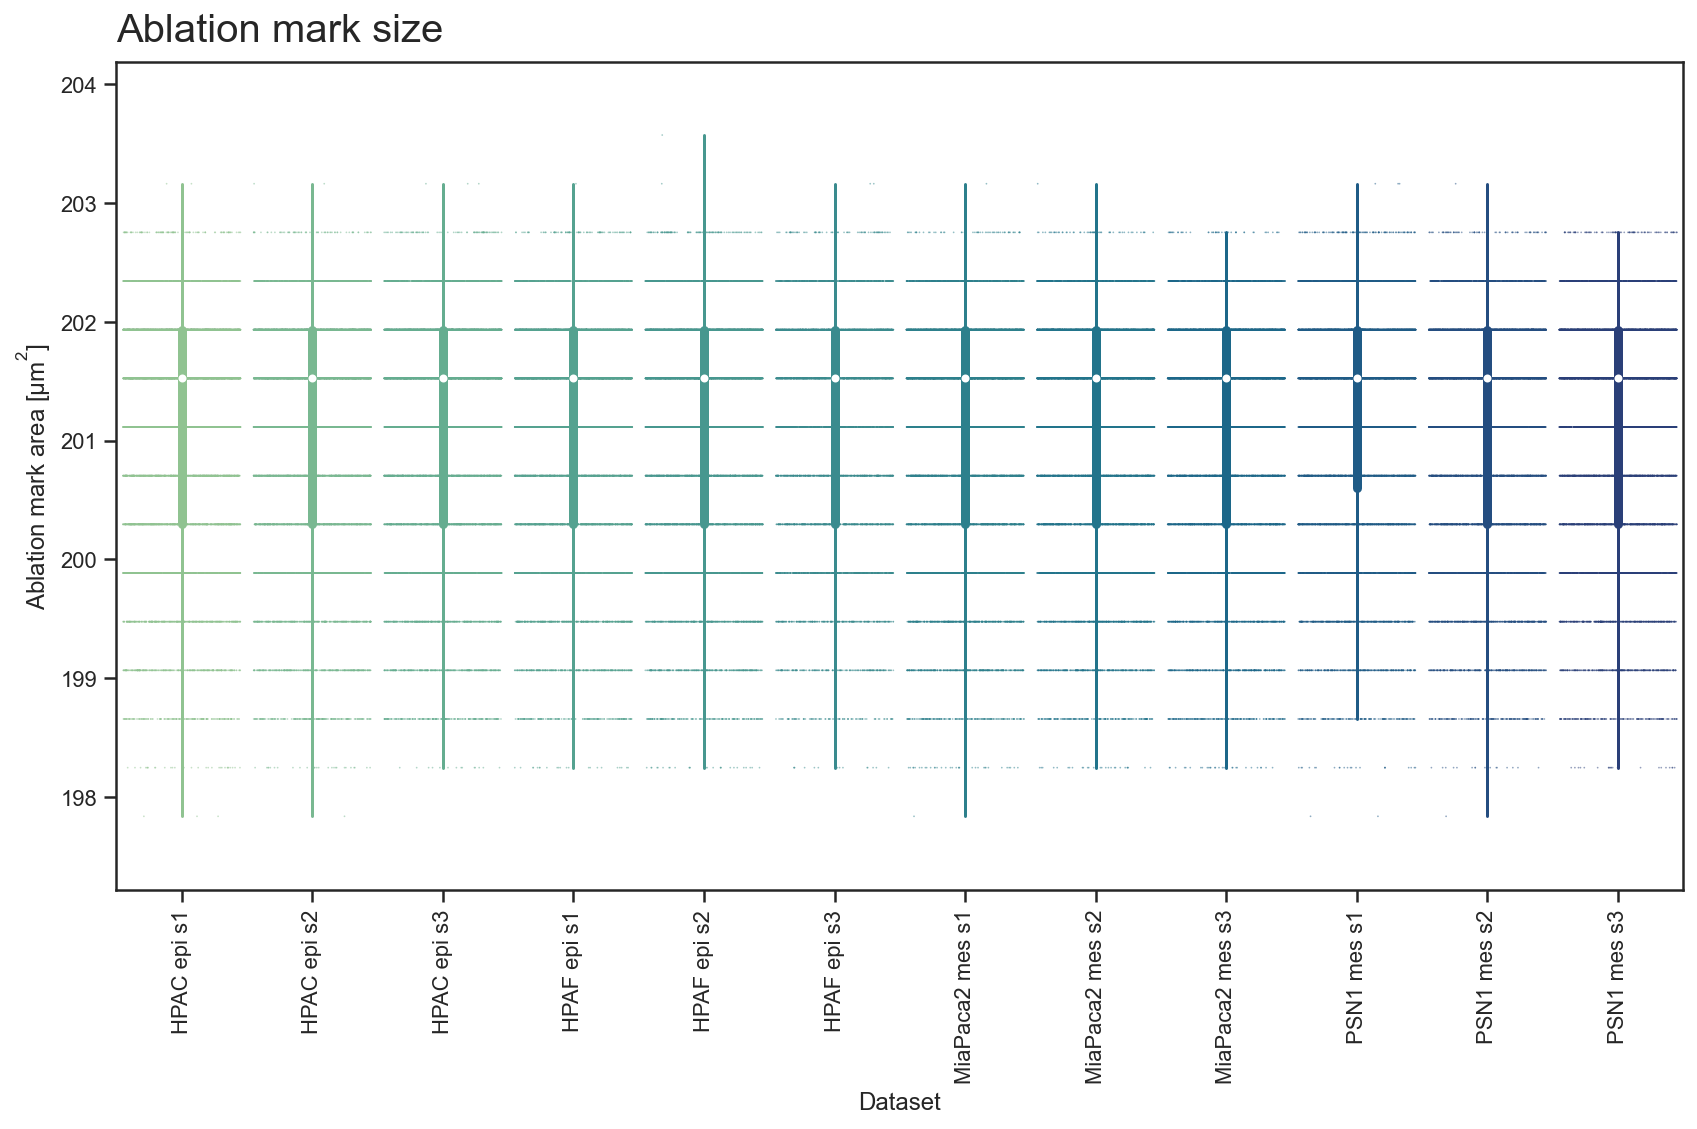

In [15]:
am_mat = am_matrix.sort_values(by=["dataset"]) #order values in x

fig = plt.figure(figsize=(n_datasets, 8))
stradivari_plot(am_mat, x="dataset", y="am_area_um2")

plt.ylabel("Ablation mark area [$\mathregular{\mu m^2}$]")
plt.xlabel("Dataset")
plt.xticks(rotation=90) #rotate xticks
plt.title("Ablation mark size", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
plt.savefig('_AblationMarkSize.png')
plt.show()

In [16]:
am_images = am_matrix.groupby(["dataset"]).apply(lambda x: x.pivot(index="x", columns="y", values="am_area_um2").values).reset_index()
am_images.columns = ["dataset", "image"]
am_images.sort_values("dataset", inplace=True)

MemoryError: Unable to allocate 3.75 GiB for an array with shape (4325, 116400) and data type float64

In [17]:
def plot_am_image(image, color, cmap="viridis"):
    d = plt.imshow(image.iloc[0], cmap=cmap, interpolation="None")

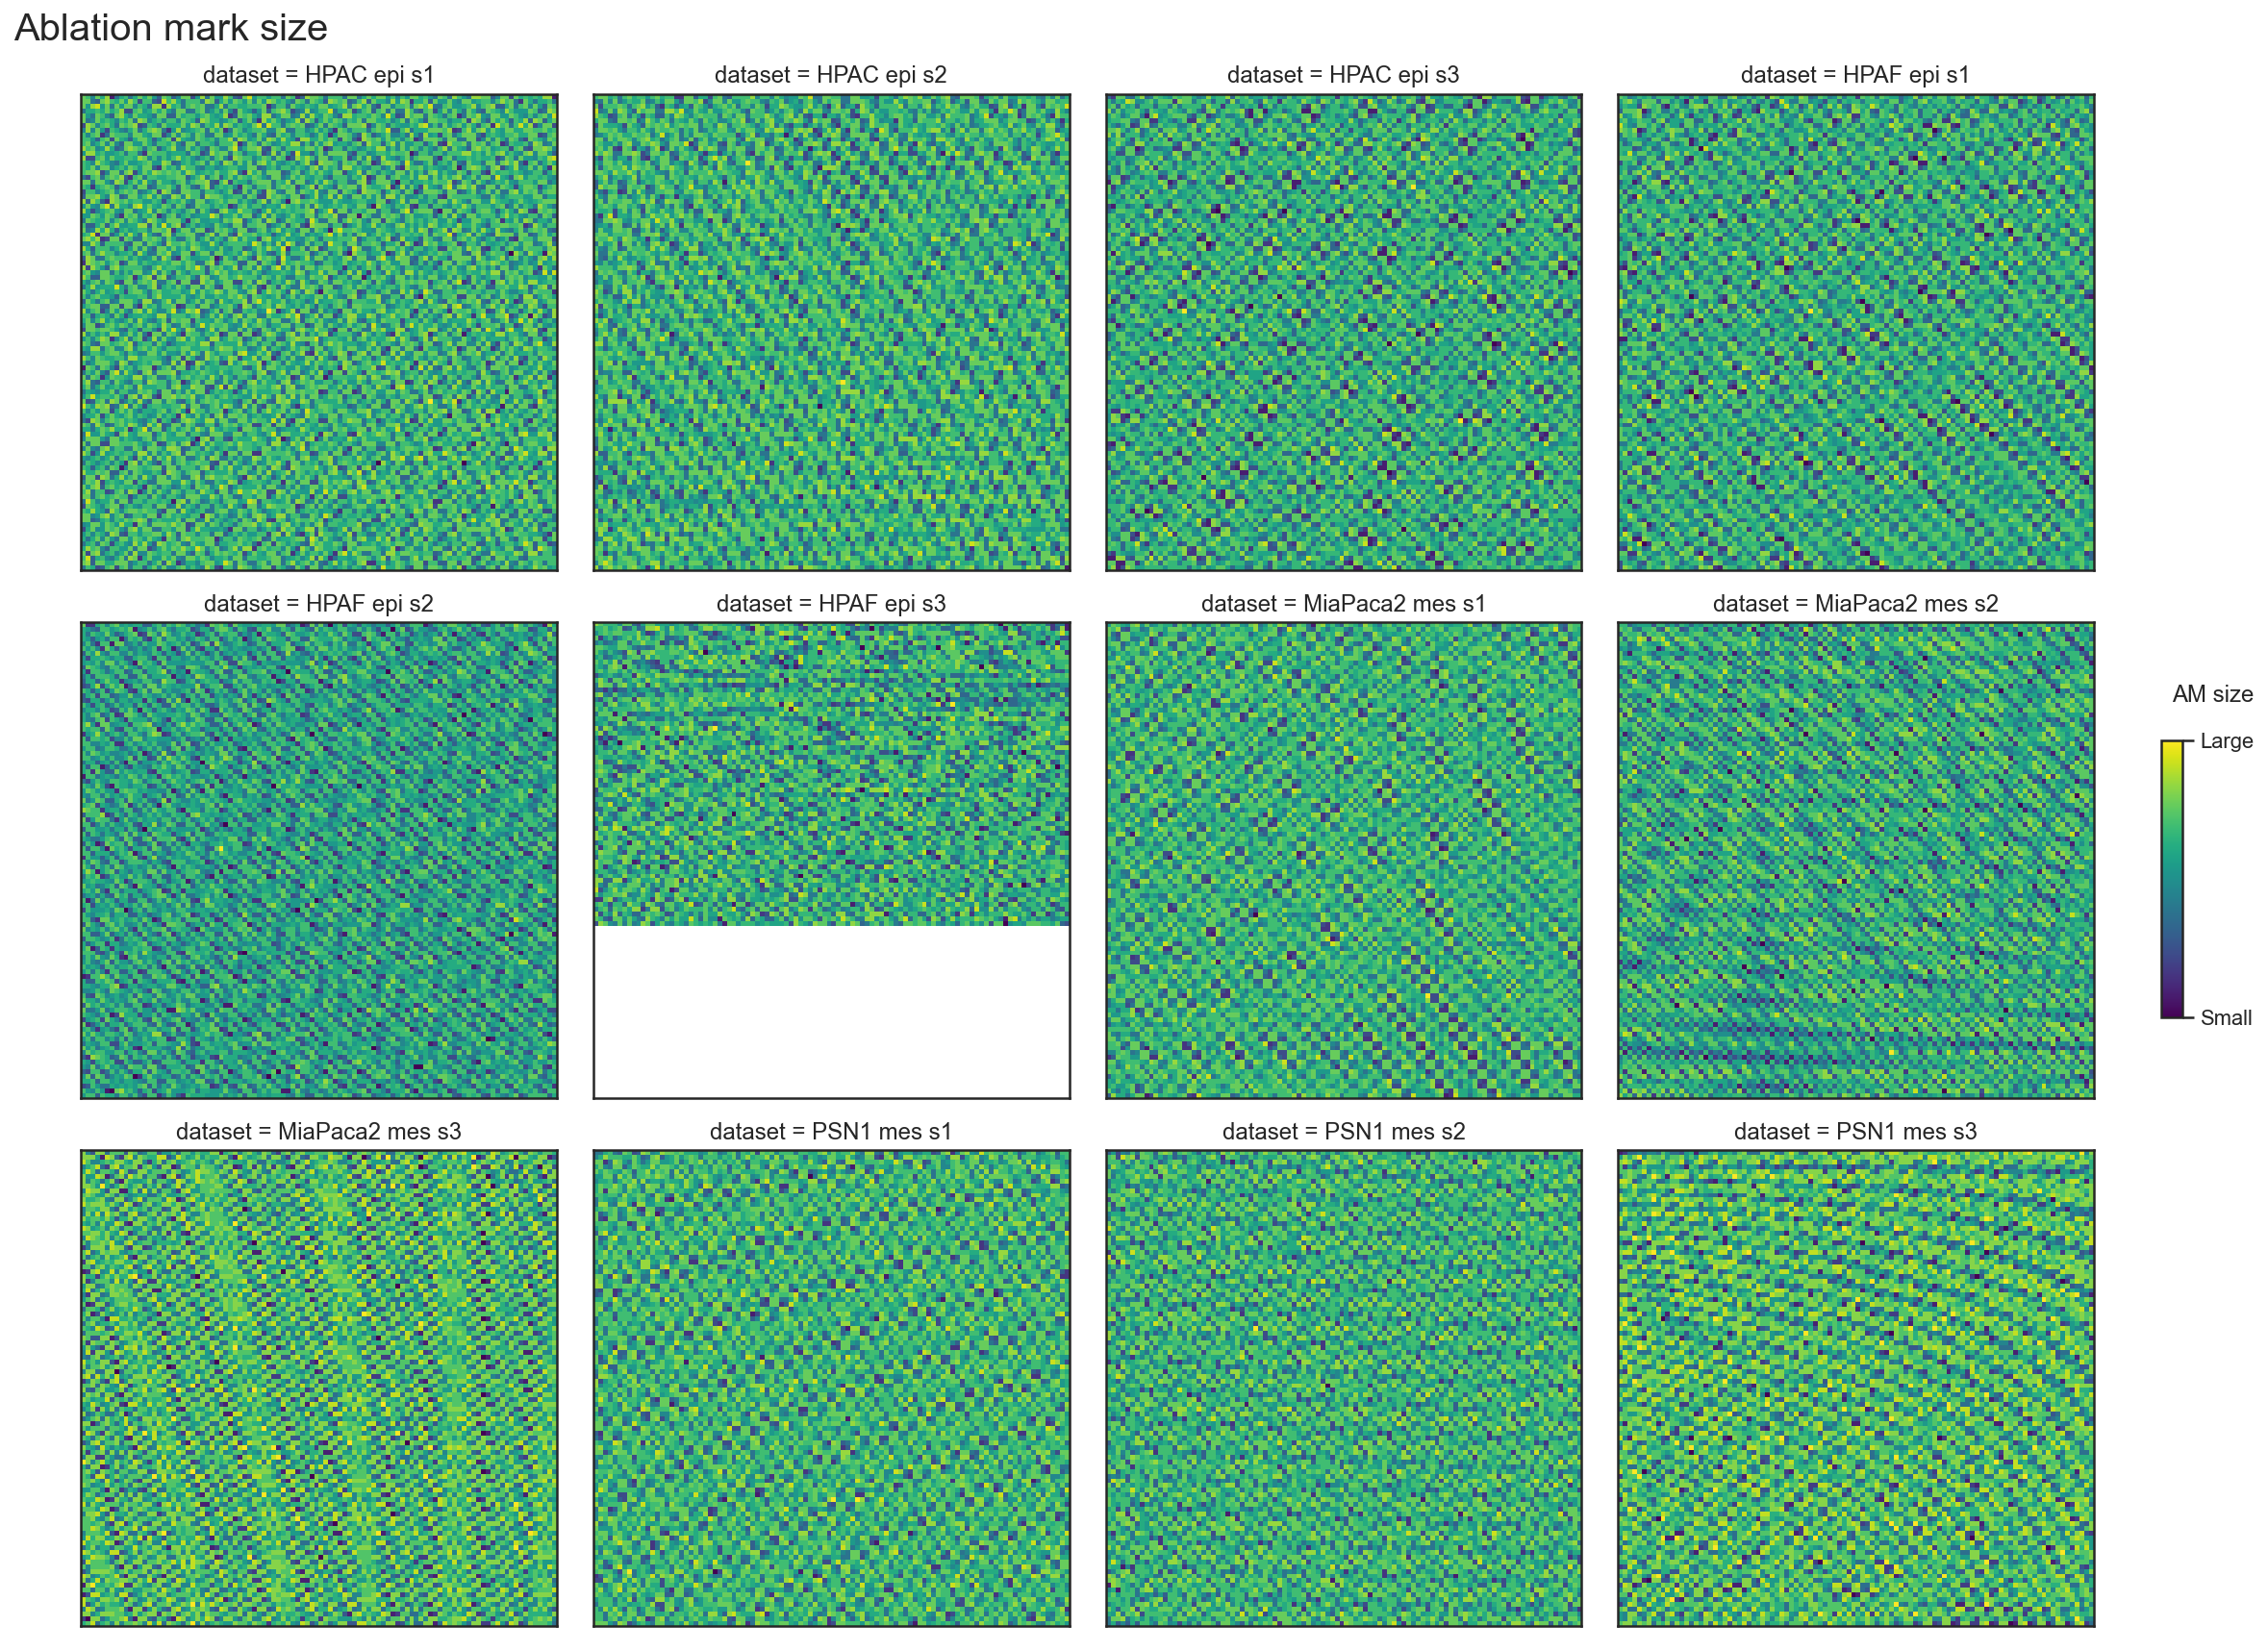

In [25]:
g = sns.FacetGrid(
    data=am_images,
    col="dataset",
    col_wrap=4,
    height=4,
    aspect=0.95,
    legend_out=True,
    despine=False,
)

g.map(plot_am_image, "image")

g.set(xticks=[], yticks=[], xlabel=None)

# Add colorbar
cb_h = 0.5 / g._nrow
cb_ax = g.fig.add_axes([1.02, 0.5 - (cb_h / 2), 0.01, cb_h])
cb = plt.colorbar(g.axes.flatten()[0].get_images()[0], cax=cb_ax)
cb.set_ticks([cb.vmin, cb.vmax])
cb_ax.set_title("AM size", y=1.1, ha="left")
cb_ax.set_yticklabels(["Small", "Large"])


plt.suptitle("Ablation mark size", size=20, x=0, y=1, ha="left", va="bottom")
plt.show()

**Note:** Colors are not comparable across datasets!

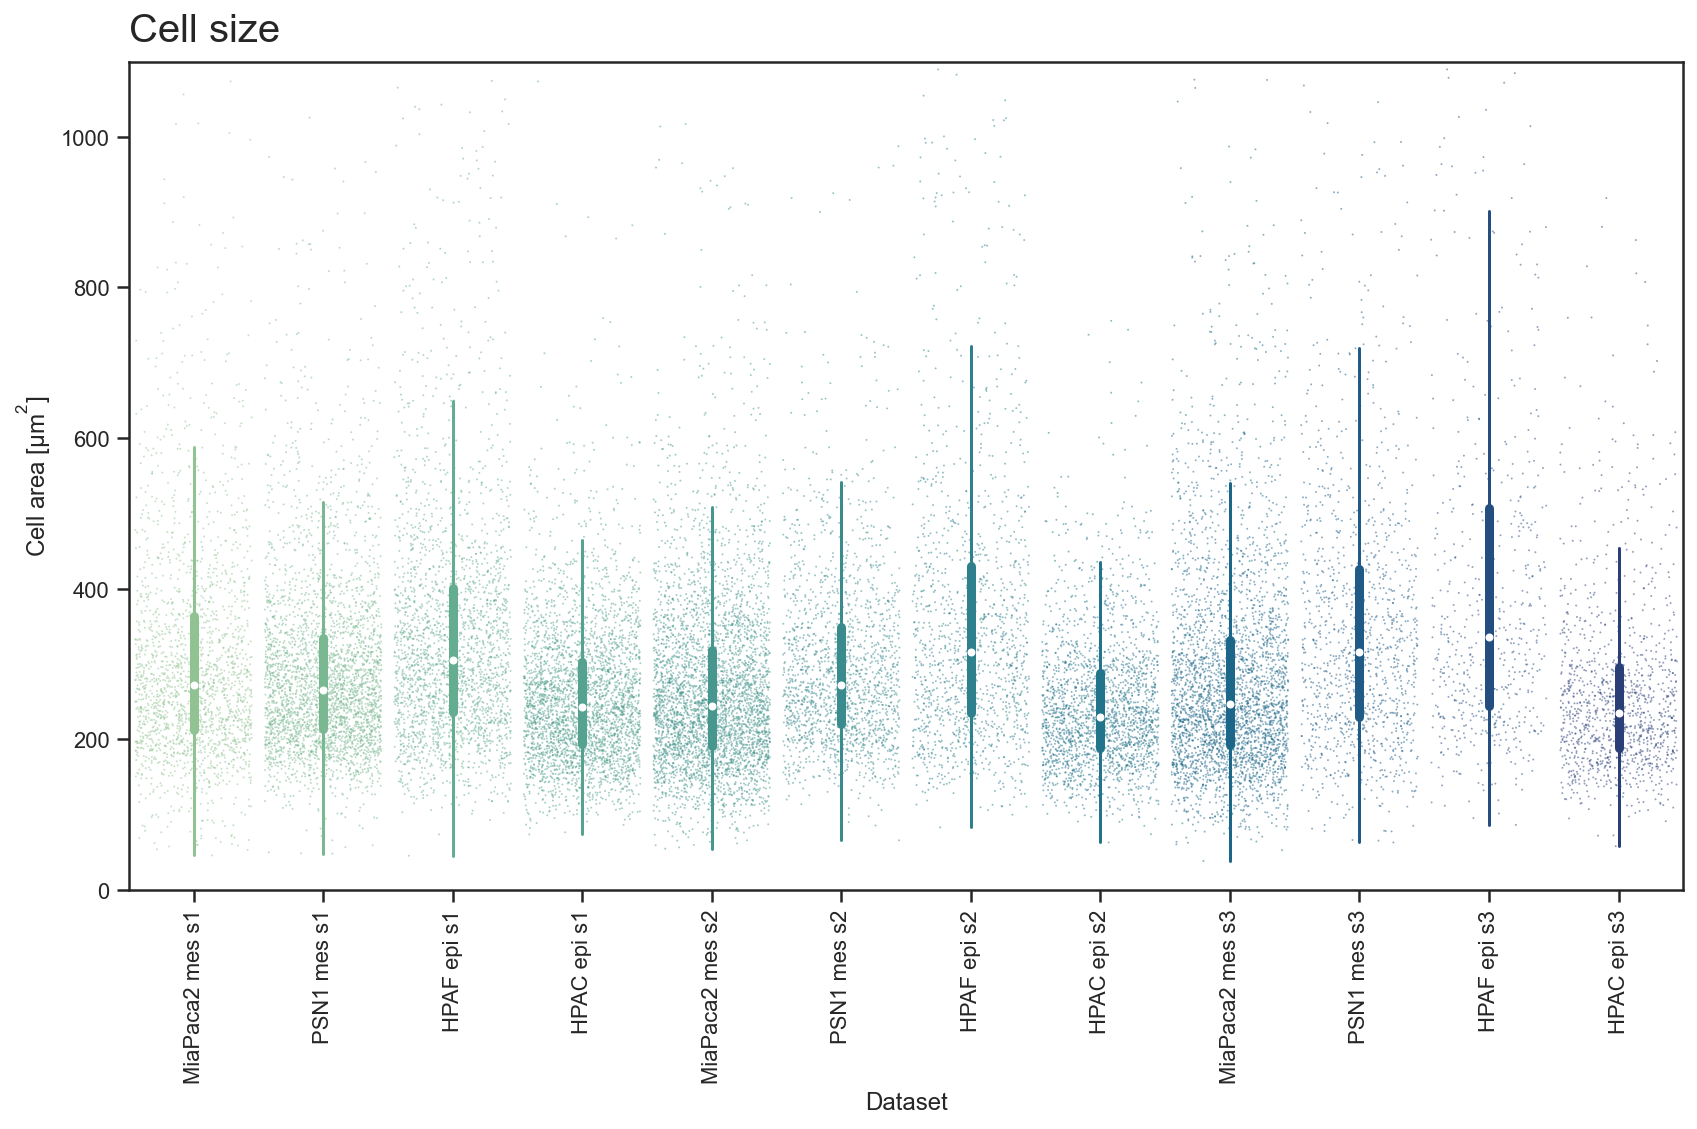

In [19]:
fig = plt.figure(figsize=(n_datasets, 8))

stradivari_plot(sc_matrix, x="dataset", y="cell_area_um2")

plt.ylabel("Cell area [$\mathregular{\mu m^2}$]")
plt.xlabel("Dataset")
ax = plt.gca()
ax.set_ylim([0, 1100])
plt.xticks(rotation=90) #rotate xticks
plt.title("Cell size", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
#plt.savefig('BiggOverlap_CellSize.png')
plt.show()

## Same Plot but IN ORDER

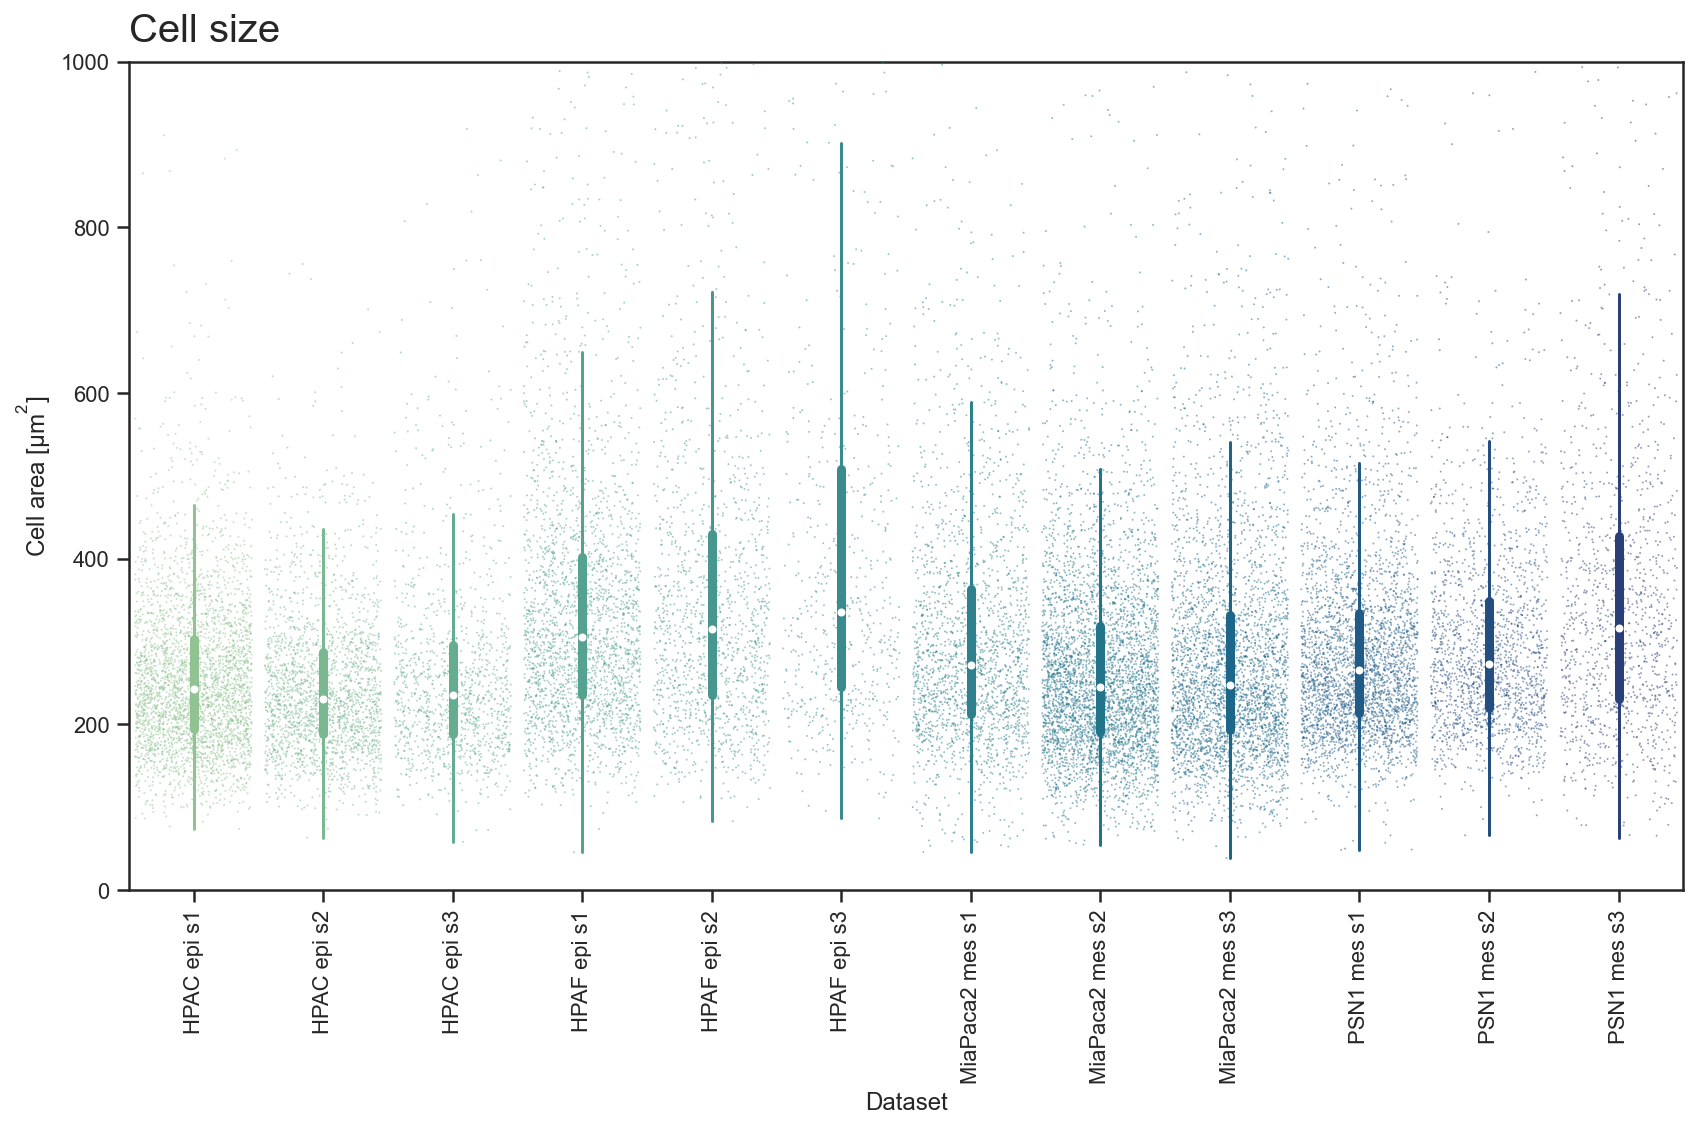

In [24]:
sc_mat = sc_matrix.sort_values(by=["dataset"])

fig = plt.figure(figsize=(n_datasets, 8))

stradivari_plot(sc_mat, x="dataset", y="cell_area_um2")

plt.ylabel("Cell area [$\mathregular{\mu m^2}$]")
ax = plt.gca()
ax.set_ylim([0, 1000])
plt.xlabel("Dataset")
plt.xticks(rotation=90) #rotate xticks
plt.title("Cell size", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
plt.savefig('BiggOverlap_CellSize.png')
plt.show()

In [18]:
sc_matrix.groupby(["dataset"])["cell_area_um2"].median()

dataset
s1/w5    271.5648
s1/w6    265.0112
s1/w7    305.5616
s1/w8    242.4832
s2/w5    244.9408
s2/w6    272.3840
s2/w7    315.3920
s2/w8    230.1952
s3/w5    246.9888
s3/w6    316.2112
s3/w7    335.2576
s3/w8    235.5200
Name: cell_area_um2, dtype: float64

In [19]:
sc_matrix.groupby(["dataset"])["cell_area_um2"].std()

dataset
s1/w5    153.312688
s1/w6    126.499131
s1/w7    209.438948
s1/w8     95.114824
s2/w5    118.507537
s2/w6    115.469970
s2/w7    246.140388
s2/w8     86.096966
s3/w5    141.592056
s3/w6    210.165407
s3/w7    333.954468
s3/w8    125.468699
Name: cell_area_um2, dtype: float64

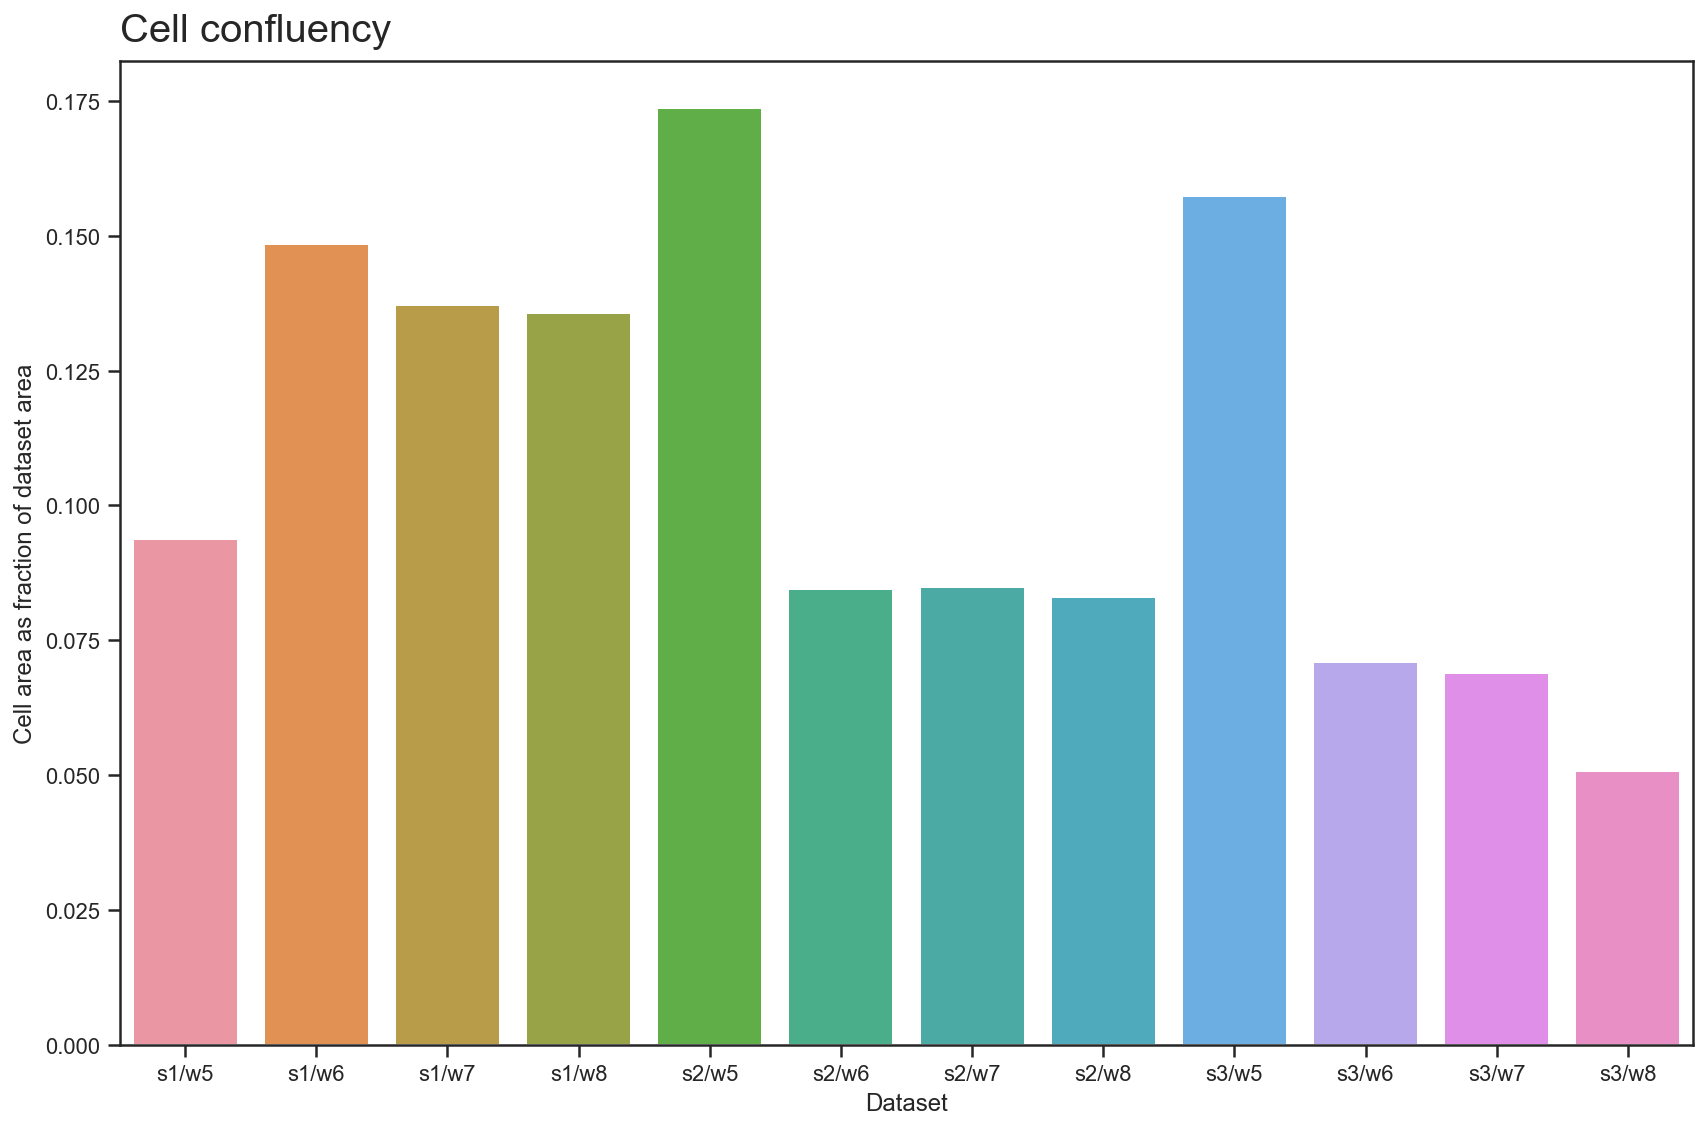

In [20]:
ds_areas = (
    am_matrix.groupby(["dataset"])[["center_x", "center_y"]]
    .agg(lambda x: np.ptp(x.values))
    .product(axis=1)
)
ds_areas.name = "dataset_area"
agg_df = sc_matrix.groupby(["dataset"])["cell_area"].sum().reset_index()
agg_df = agg_df.merge(ds_areas, on="dataset")
agg_df["cell_area_fraction"] = agg_df["cell_area"] / agg_df["dataset_area"]

fig = plt.figure(figsize=(n_datasets, 8))

sns.barplot(data=agg_df, x="dataset", y="cell_area_fraction")

plt.ylabel("Cell area as fraction of dataset area")
plt.xlabel("Dataset")
plt.title("Cell confluency", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
plt.savefig('BiggOverlap_CellConfluence.png')
plt.show()

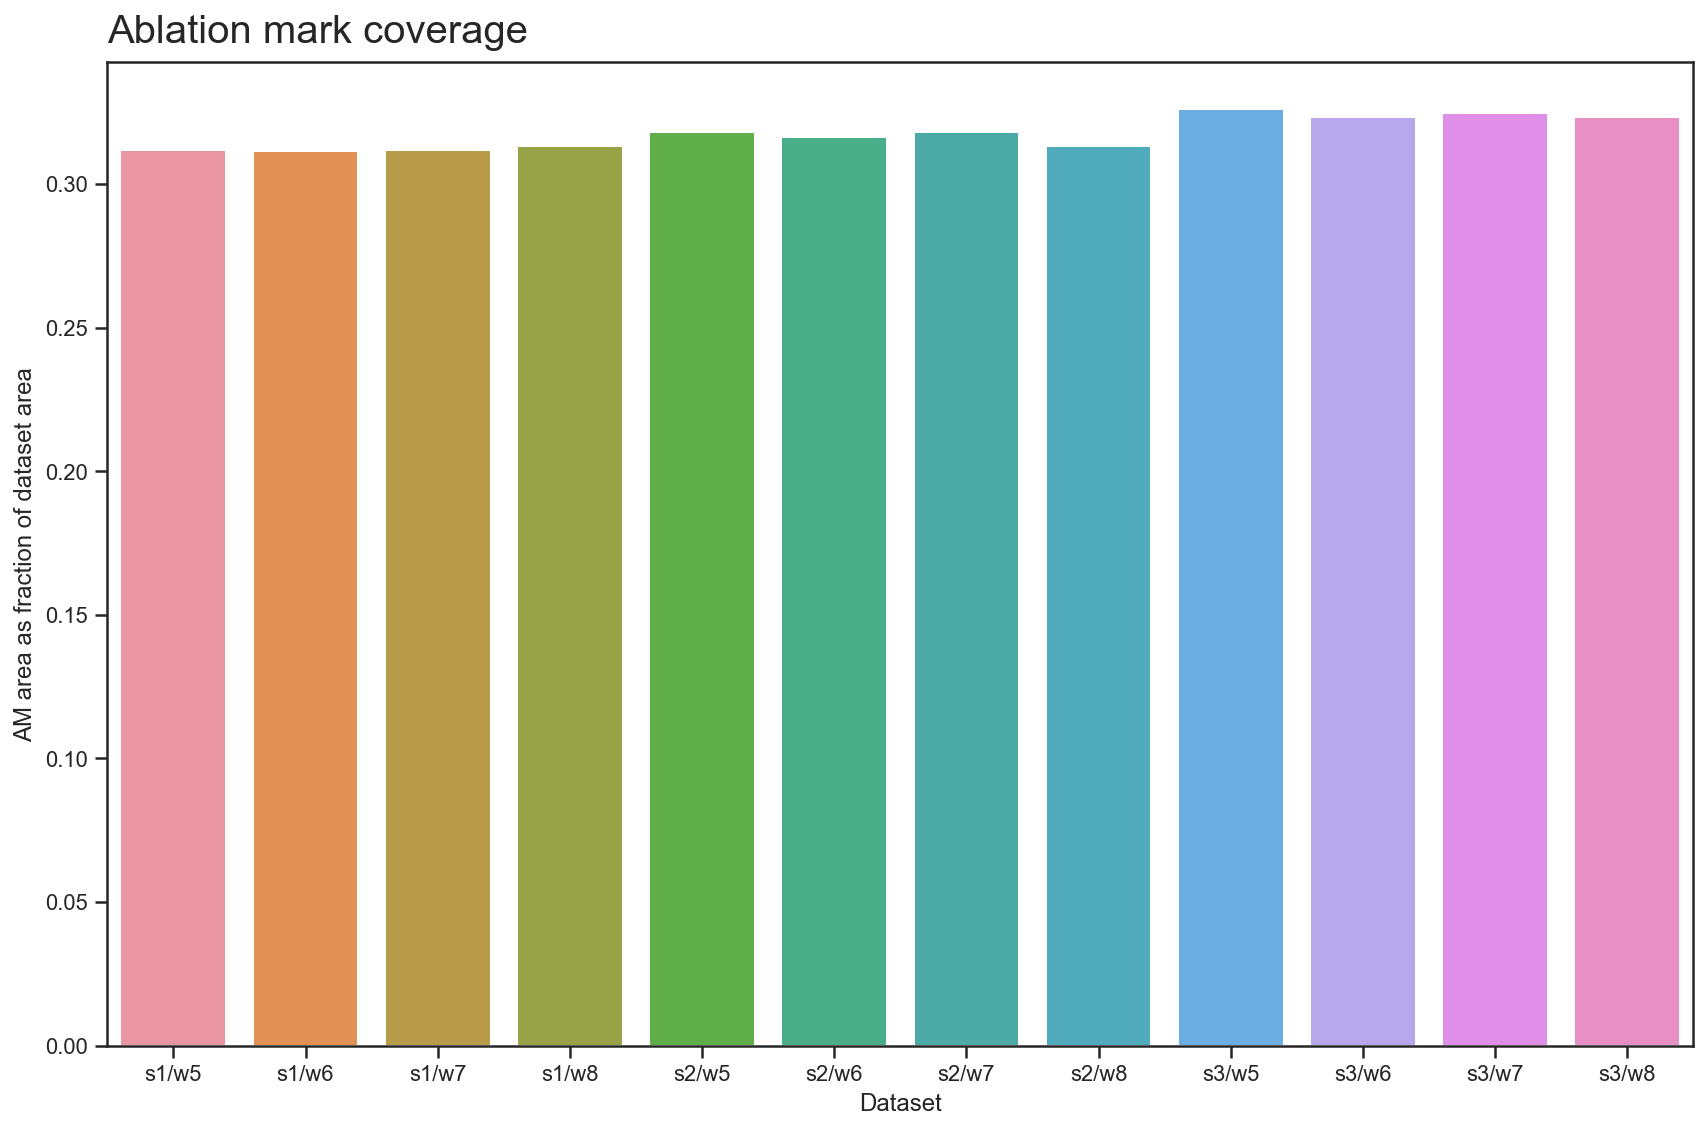

In [21]:
agg_df = am_matrix.groupby(["dataset"])["am_area"].sum().reset_index()
agg_df = agg_df.merge(ds_areas, on="dataset")
agg_df["am_area_fraction"] = agg_df["am_area"] / agg_df["dataset_area"]

fig = plt.figure(figsize=(n_datasets, 8))

sns.barplot(data=agg_df, x="dataset", y="am_area_fraction")

plt.ylabel("AM area as fraction of dataset area")
plt.xlabel("Dataset")
plt.title("Ablation mark coverage", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
plt.savefig('BiggOverlap_AblationMarkCoverage.png')
plt.show()

In [22]:
sc_mat["binning_x"] = sc_matrix.groupby(["dataset"])["center_x"].apply(lambda x: pd.cut(x, bins=3))
sc_mat["binning_y"] = sc_matrix.groupby(["dataset"])["center_y"].apply(lambda x: pd.cut(x, bins=3))

C:\Users\Jeany\AppData\Local\Temp/ipykernel_10228/1061075991.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sc_mat["binning_x"] = sc_matrix.groupby(["dataset"])["center_x"].apply(lambda x: pd.cut(x, bins=3))
C:\Users\Jeany\AppData\Local\Temp/ipykernel_10228/1061075991.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sc_mat["binning_y"] = sc_matrix.groupby(["dataset"])["center_y"].apply(lambda x: pd.cut(x, bins=3))


In [23]:
from itertools import product
from matplotlib.patches import Rectangle


def draw_binning(binning_x, binning_y, color):
    uniq_x, uniq_y = binning_x.sort_values().unique(), binning_y.sort_values().unique()
    cmap = sns.color_palette("hls", len(uniq_x) * len(uniq_y))
    ax = plt.gca()

    for idx, (ylims, xlims) in enumerate(product(uniq_y, uniq_x)):
        x, w = xlims.left, xlims.length
        y, h = ylims.left, ylims.length

        rect = Rectangle(
            xy=(x, y),
            height=h,
            width=w,
            facecolor=cmap[idx],
            fill=True,
            linewidth=0,
            alpha=0.3,
        )

        ax.add_patch(rect)

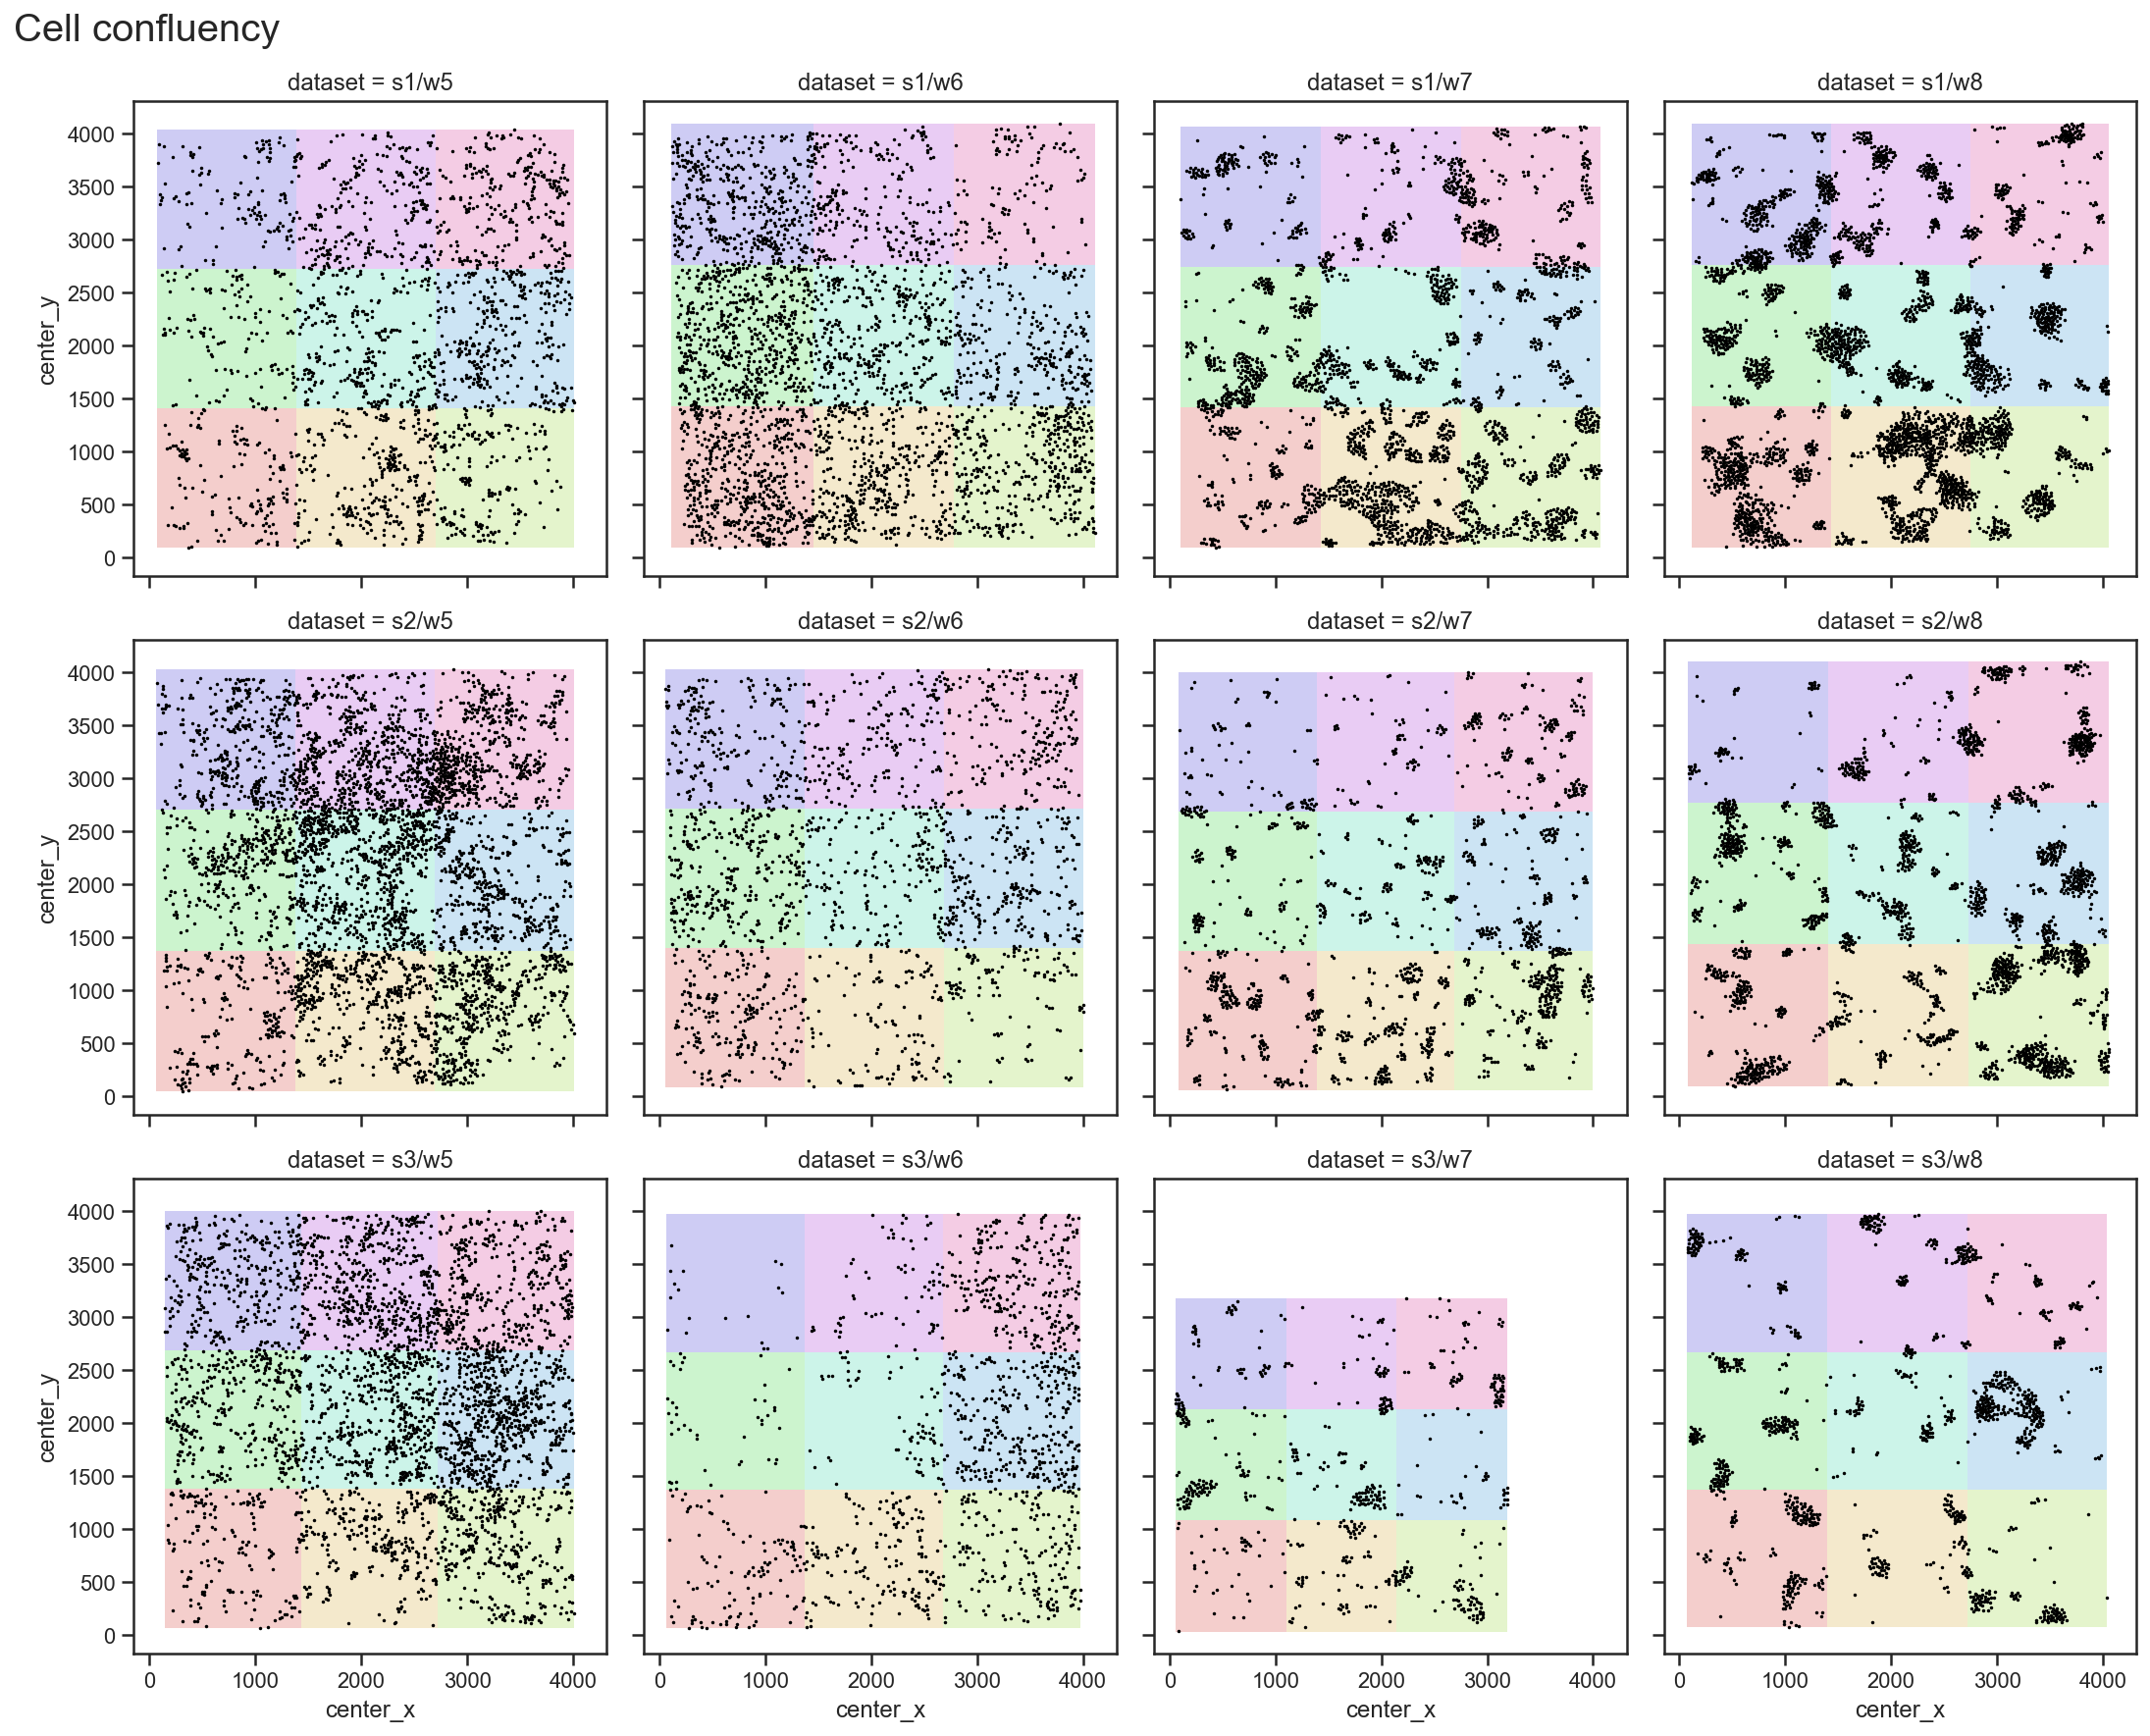

In [24]:
g = sns.FacetGrid(
    data=sc_mat, col="dataset", col_wrap=4, height=4, aspect=0.95, despine=False
)

g.map(draw_binning, "binning_x", "binning_y")

g.map(sns.scatterplot, "center_x", "center_y", linewidth=0, s=3, color="black")

for ax in g.axes:
    plt.setp(ax.collections, zorder=100, label="")

plt.suptitle("Cell confluency", size=20, x=0, y=1, ha="left", va="bottom")
plt.savefig('BiggOverlap_CellConfluence.png')
plt.show()

In [25]:
def calc_local_confluency(sm_matrix):
    x_range = np.ptp(sm_matrix.center_x) * um_per_px
    y_range = np.ptp(sm_matrix.center_y) * um_per_px
    area = x_range * y_range
    area_ratio = (len(sm_matrix) / area) * 1000 ** 2
    return area_ratio

In [26]:
binned_confluency = (
    sc_matrix.groupby(["dataset", "binning_x", "binning_y"])
    .apply(calc_local_confluency)
    .reset_index()
)

fig = plt.figure(figsize=(n_datasets, 8))

sns.boxplot(data=binned_confluency, x="dataset", y=0, showfliers=False)

sns.stripplot(data=binned_confluency, x="dataset", y=0, color="0.3")
plt.ylim(bottom=0)
plt.ylabel("Cells / mm²")
plt.xlabel("Dataset")

plt.title("Local cell confluency", size=20, x=0, ha="left", va="bottom")
plt.savefig('LocalCellConfluency.png')
plt.show()

KeyError: 'binning_x'

In [ ]:
fig = plt.figure(figsize=(n_datasets, 8))

stradivari_plot(sc_mat, x="dataset", y="cell_sampling_ratio")

plt.ylabel("Fraction of cell sampled by ablation marks")
plt.xlabel("Dataset")
plt.title("Cell sampling ratio", size=20, x=0, ha="left", va="bottom")
plt.tight_layout()
plt.savefig('CellSamplingRatio.png')
plt.show()